<a href="https://colab.research.google.com/github/alecona/QNN/blob/main/quant_classic(1_0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-quantum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 5.4 MB/s 
     |████████████████████████████████| 6.1 MB 54.5 MB/s 
     |████████████████████████████████| 1.8 MB 47.4 MB/s 
     |████████████████████████████████| 100 kB 12.8 MB/s 
     |████████████████████████████████| 90 kB 12.9 MB/s 
     |████████████████████████████████| 541 kB 73.0 MB/s 
     |████████████████████████████████| 90 kB 12.0 MB/s 
     |████████████████████████████████| 93 kB 2.2 MB/s 
     |████████████████████████████████| 93 kB 2.3 MB/s 
     |████████████████████████████████| 93 kB 2.2 MB/s 
     |████████████████████████████████| 93 kB 2.4 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 93 kB 2.1 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 
     |████████████████████████████████| 92 kB 1.5

In [ ]:
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [ ]:
import tensorflow as tf

import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11501568/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [ ]:
def filter_10(x, y):
    keep = (y == 1) | (y == 0)
    x, y = x[keep], y[keep]
    y = y == 1
    return x,y

In [ ]:
x_train, y_train = filter_10(x_train, y_train)
x_test, y_test = filter_10(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12665
Number of filtered test examples: 2115


False


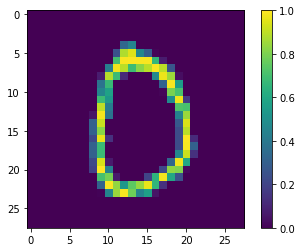

In [ ]:
print(y_test[120])

plt.imshow(x_test[120, :, :, 0])
plt.colorbar()

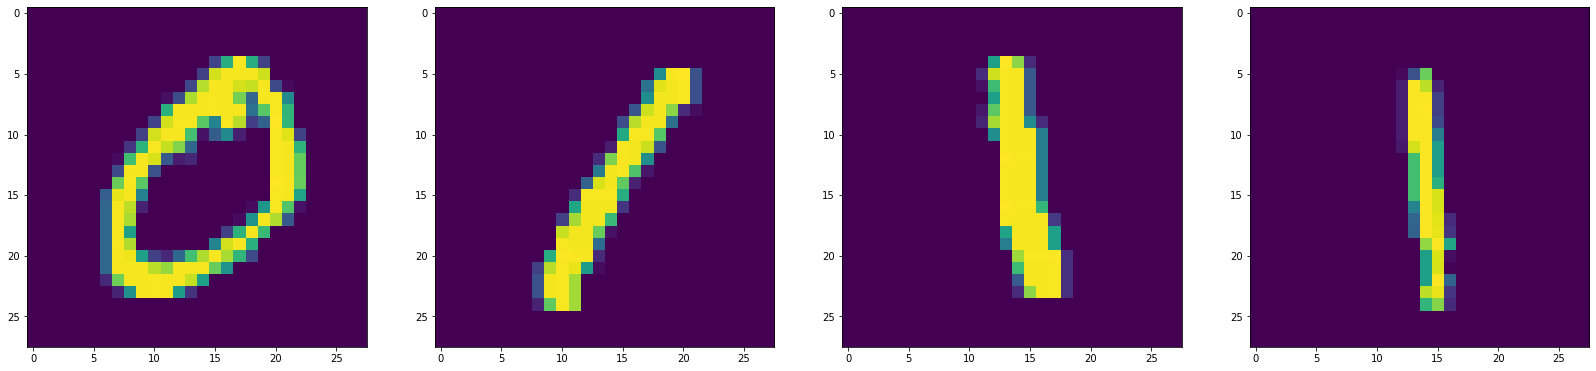

In [ ]:
plt.figure(figsize=(28,28))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[i,:,:,0])
plt.show()

In [ ]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

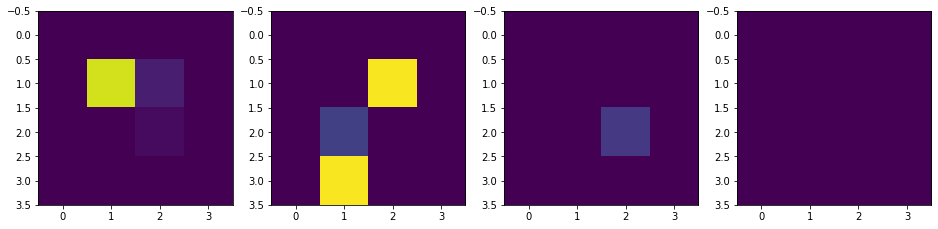

In [ ]:
plt.figure(figsize=(16,16))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train_small[i,:,:,0], vmin=0, vmax=1)
plt.show()

In [ ]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          
          pass

    num_uniq_1 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_0 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 1s: ", num_uniq_1)
    print("Number of unique 0s: ", num_uniq_0)
    print("Number of unique contradicting labels (both 1 and 0): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [ ]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 7100
Number of unique 1s:  2068
Number of unique 0s:  4924
Number of unique contradicting labels (both 1 and 0):  108

Initial number of images:  12665
Remaining non-contradicting unique images:  6992


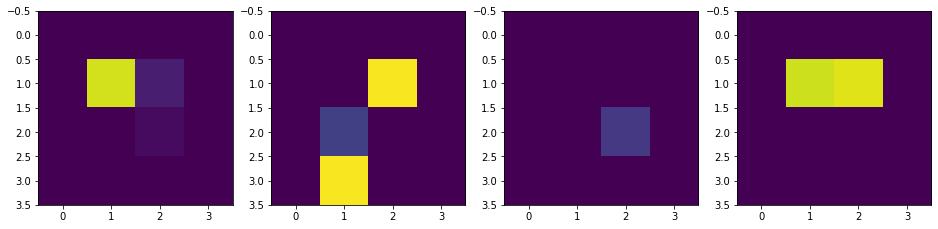

In [ ]:
plt.figure(figsize=(16,16))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train_nocon[i,:,:,0], vmin=0, vmax=1)
plt.show()

In [ ]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

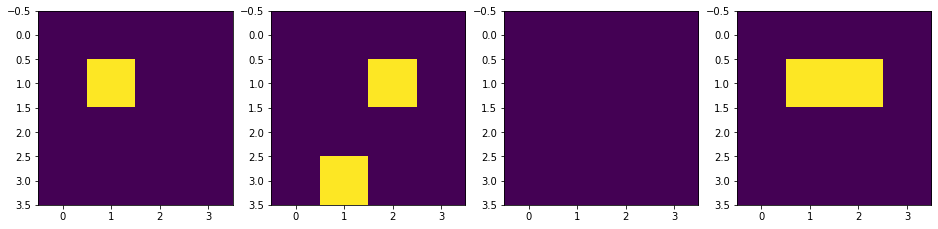

In [ ]:
plt.figure(figsize=(16,16))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train_bin[i,:,:,0])
plt.show()

In [ ]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 126
Number of unique 1s:  5
Number of unique 0s:  88
Number of unique contradicting labels (both 1 and 0):  33

Initial number of images:  6992
Remaining non-contradicting unique images:  93


In [ ]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4,4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


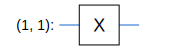

In [ ]:
SVGCircuit(x_train_circ[0])

In [ ]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[1, 1]])

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

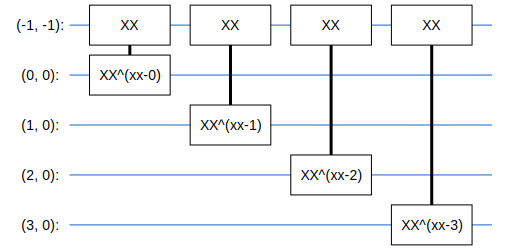

In [ ]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [ ]:
def create_quantum_model():
   
    data_qubits = cirq.GridQubit.rect(4, 4)  
    readout = cirq.GridQubit(-1, -1)         
    circuit = cirq.Circuit()

    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

 
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")
    # added one more layer
    #builder.add_layer(circuit, cirq.ZZ, "zz2")

    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
model_circuit, model_readout = create_quantum_model()

In [ ]:

model = tf.keras.Sequential([
   
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
with tf.device('/GPU:0'):
  qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
219/219 [==============================] - 603s 3s/step - loss: 0.7964 - hinge_accuracy: 0.6972 - val_loss: 0.3717 - val_hinge_accuracy: 0.8484
Epoch 2/3
219/219 [==============================] - 412s 2s/step - loss: 0.5348 - hinge_accuracy: 0.7384 - val_loss: 0.3119 - val_hinge_accuracy: 0.8484
Epoch 3/3
67/67 [==============================] - 21s 314ms/step - loss: 0.3449 - hinge_accuracy: 0.8475


In [ ]:
def create_classical_model():
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                      

In [ ]:
with tf.device('/GPU:0'):
  model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

67/67 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.9995


In [ ]:
def create_fair_classical_model():
   
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/GPU:0'):
  model.fit(x_train_bin,
          y_train_nocon,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.4951 - accuracy: 0.7041 - val_loss: 0.5438 - val_accuracy: 0.4634
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.3982 - accuracy: 0.7386 - val_loss: 0.4631 - val_accuracy: 0.4884
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.3409 - accuracy: 0.8445 - val_loss: 0.4228 - val_accuracy: 0.6345
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.3120 - accuracy: 0.8643 - val_loss: 0.4008 - val_accuracy: 0.6364
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.2978 - accuracy: 0.8660 - val_loss: 0.3877 - val_accuracy: 0.6364
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.2905 - accuracy: 0.8656 - val_loss: 0.3847 - val_accuracy: 0.6364
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.2867 - accuracy: 0.8656 - val_loss: 0.3786 - val_accuracy: 0.6364
Epoch 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


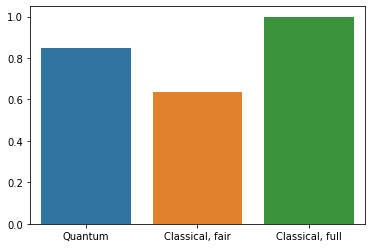

In [ ]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, fair", "Classical, full"],
            [qnn_accuracy, fair_nn_accuracy, cnn_accuracy])